This notebook plots maps of 2016-mean precipitation bias in prognostic runs. It depends on diagnostics computed by the `prognostic-reports` workflow.

It generates Figure 4 and Figure S4.

In [1]:
import xarray as xr
import fsspec
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
import numpy as np
import cartopy.crs as ccrs
matplotlib.rcParams['figure.dpi'] = 150
xr.set_options(keep_attrs=True)

### Load time-mean lat-lon diagnostics for three runs

In [2]:
url_format = 'gs://vcm-ml-public/argo/2020-11-10-n2o-climate-runs/{experiment}/diags_latlon.nc'
experiments = ['baseline', 'rf-control', 'rf-dQ1-dQ2-only']

In [3]:
diags = []
for run in experiments:
    url = url_format.format(experiment=run)
    with fsspec.open(url) as f:
        ds = xr.open_dataset(f).load()
        diags.append(ds.assign_coords(experiment=run))
diags = xr.concat(diags, dim='experiment')
diags = diags.rename(grid_xt='longitude', grid_yt='latitude')

In [4]:
def global_rmse(ds):
    w = np.cos(np.deg2rad(ds.latitude))
    squared_errors = ds ** 2
    zonal_mean_squared_errors = squared_errors.mean('longitude')
    mean_squared_errors = (zonal_mean_squared_errors * w).sum('latitude') / w.sum('latitude')
    return np.sqrt(mean_squared_errors)


def global_bias(ds):
    w = np.cos(np.deg2rad(ds.latitude))
    zonal_mean_bias = ds.mean('longitude')
    return (zonal_mean_bias * w).sum('latitude') / w.sum('latitude')

### Compute global-mean RMSE and bias of time-mean maps

In [5]:
bias_variables = [v for v in diags if 'time_mean_bias' in v]
rmse_df = global_rmse(diags[bias_variables]).to_dataframe().T
bias_df = global_bias(diags[bias_variables]).to_dataframe().T

### Now compare precipitation with GPCP

Taking $P-<dQ2>$ as precipitation from prognostic runs.

In [6]:
url_gpcp = 'gs://vcm-ml-raw/2020-11-10-GPCP-2015-2016/gpcp_v01r03_daily.zarr'
m = fsspec.get_mapper(url_gpcp)
ds_gpcp = xr.open_zarr(m, consolidated=True)
# shift lat/lon labels to center of grid cells
ds_gpcp = ds_gpcp.assign_coords(latitude=ds_gpcp.latitude + 0.5, longitude=ds_gpcp.longitude + 0.5)

In [7]:
ds_gpcp

<xarray.Dataset>
Dimensions:      (latitude: 180, longitude: 360, nv: 2, time: 731)
Coordinates:
  * latitude     (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude    (longitude) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time         (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2016-12-31
Dimensions without coordinates: nv
Data variables:
    lat_bounds   (time, latitude, nv) float32 dask.array<chunksize=(30, 180, 2), meta=np.ndarray>
    lon_bounds   (time, longitude, nv) float32 dask.array<chunksize=(30, 360, 2), meta=np.ndarray>
    precip       (time, latitude, longitude) float32 dask.array<chunksize=(30, 180, 360), meta=np.ndarray>
    time_bounds  (time, nv) object dask.array<chunksize=(731, 2), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.6, ACDD 1.3
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    acknowledgment:             This project was supported in part by a grant...
    cdm_data_type:              Grid
    cdr_program:                NOAA Climate Data Record Program for satellit...
    cdr_variable:               precipitation
    comment:                    Processing computer: eagle2.umd.edu
    contributor_name:           Robert Adler, Jian-Jian Wang
    contributor_role:           principalInvestigator, processor and custodian
    creator_email:              jjwang@umd.edu
    creator_name:               Dr. Jian-Jian Wang
    date_created:               2017-05-30T17:15:51Z
    geospatial_lat_max:         90.0
    geospatial_lat_min:         -90.0
    geospatial_lat_resolution:  1 degree
    geospatial_lat_units:       degrees_north
    geospatial_lon_max:         360.0
    geospatial_lon_min:         0.0
    geospatial_lon_resolution:  1 degree
    geospatial_lon_units:       degrees_east
    history:                    1) 2017-05-30T17:15:51Z, Dr. Jian-Jian Wang, ...
    id:                         201501/gpcp_v01r03_daily_d20150101_c20170530.nc
    institution:                ACADEMIC > UMD/ESSIC > Earth System Science I...
    keywords:                   EARTH SCIENCE > ATMOSPHERE > PRECIPITATION > ...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ea...
    license:                    No constraints on data access or use.
    metadata_link:              gov.noaa.ncdc:XXXXX
    naming_authority:           gov.noaa.ncdc
    platform:                   GOES (Geostationary Operational Environmental...
    processing_level:           NASA Level 3
    product_version:            v01r03
    project:                    GPCP > Global Precipitation Climatology Project
    publisher_email:            jjwang@umd.edu
    publisher_name:             NOAA National Centers for Environmental Infor...
    publisher_url:              https://www.ncei.noaa.gov
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    sensor:                     Imager, AIRS > Atmospheric Infrared Sounder, ...
    source:                     /data1/GPCP_CDR/GPCP_Output/1DD//bin/201501/s...
    spatial_resolution:         1 degree
    standard_name_vocabulary:   CF Standard Name Table (v41, 22 February 2017)
    summary:                    Global Precipitation Climatology Project (GPC...
    time_coverage_duration:     P1D
    time_coverage_end:          2015-01-01T23:59:59Z
    time_coverage_start:        2015-01-01T00:00:00Z
    title:                      Global Precipitation Climatatology Project (G...

In [8]:
model_precip = diags['total_precip_time_mean_value']
# verification = forecast - bias
verif_precip = (diags.total_precip_time_mean_value - diags.total_precip_time_mean_bias)
verif_precip = verif_precip.sel(experiment="baseline").assign_coords(experiment='nudged run')
gpcp_precip = ds_gpcp['precip'].sel(time='2016').mean('time').rename('total_precip_time_mean_value').compute()
precip = xr.concat([gpcp_precip.assign_coords(experiment='GPCP'), verif_precip, model_precip], dim='experiment', join='override')
precip = precip.assign_attrs(long_name='total precipitation')

In [9]:
map_proj = ccrs.Robinson(central_longitude=180)
aspect = diags.dims['longitude'] / diags.dims['latitude']
plot_kwargs = dict(transform=ccrs.PlateCarree(), subplot_kws={'projection': map_proj}, aspect=aspect)

In [10]:
precip_bias_from_GPCP = (precip - precip.sel(experiment='GPCP')).assign_attrs(long_name='precipitation difference from GPCP')
precip_rmse = global_rmse(precip_bias_from_GPCP).to_dataframe(name='precip_rmse').T
precip_global_bias = global_bias(precip_bias_from_GPCP).to_dataframe(name='precip_bias').T

### Figure 4

Plot just baseline and rf-control

/home/OliWM/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


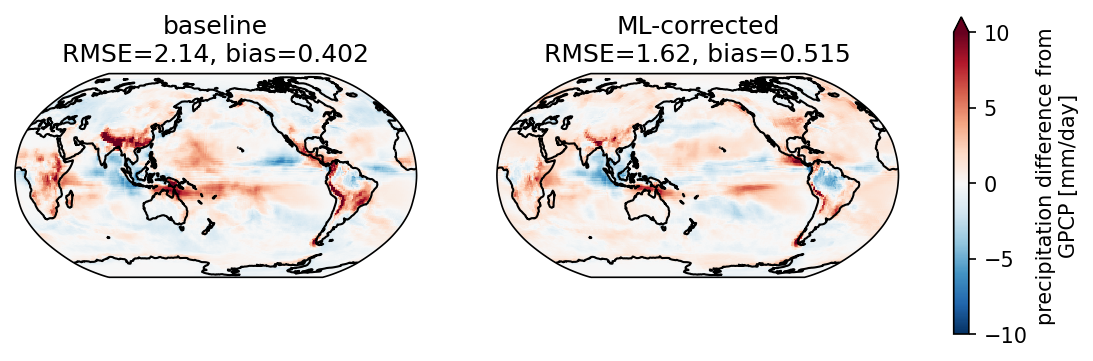

In [11]:
runs = ['baseline', 'rf-control']
run_titles = {
    'nudged run': 'nudged run',
    'baseline': 'baseline',
    'rf-control': 'ML-corrected',
    'rf-dQ1-dQ2-only': 'ML-corrected ($\Delta Q_1$, $\Delta Q_2$ only)'
}
fg = precip_bias_from_GPCP.sel(experiment=runs).plot(col='experiment', robust=True, vmin=-10, vmax=10, cmap='RdBu_r', **plot_kwargs)
for ax in fg.axes.flat:
    ax.coastlines()
for i, run in enumerate(precip_bias_from_GPCP.sel(experiment=runs).experiment):
    run_label = run.values.item()
    rmse = precip_rmse[run_label]['precip_rmse']
    bias = precip_global_bias[run_label]['precip_bias']
    fg.axes.flat[i].set_title(f"{run_titles[run_label]}\nRMSE={rmse:.3}, bias={bias:.3}")
fg.fig.set_size_inches(9.5, 2.8)

### Figure S4

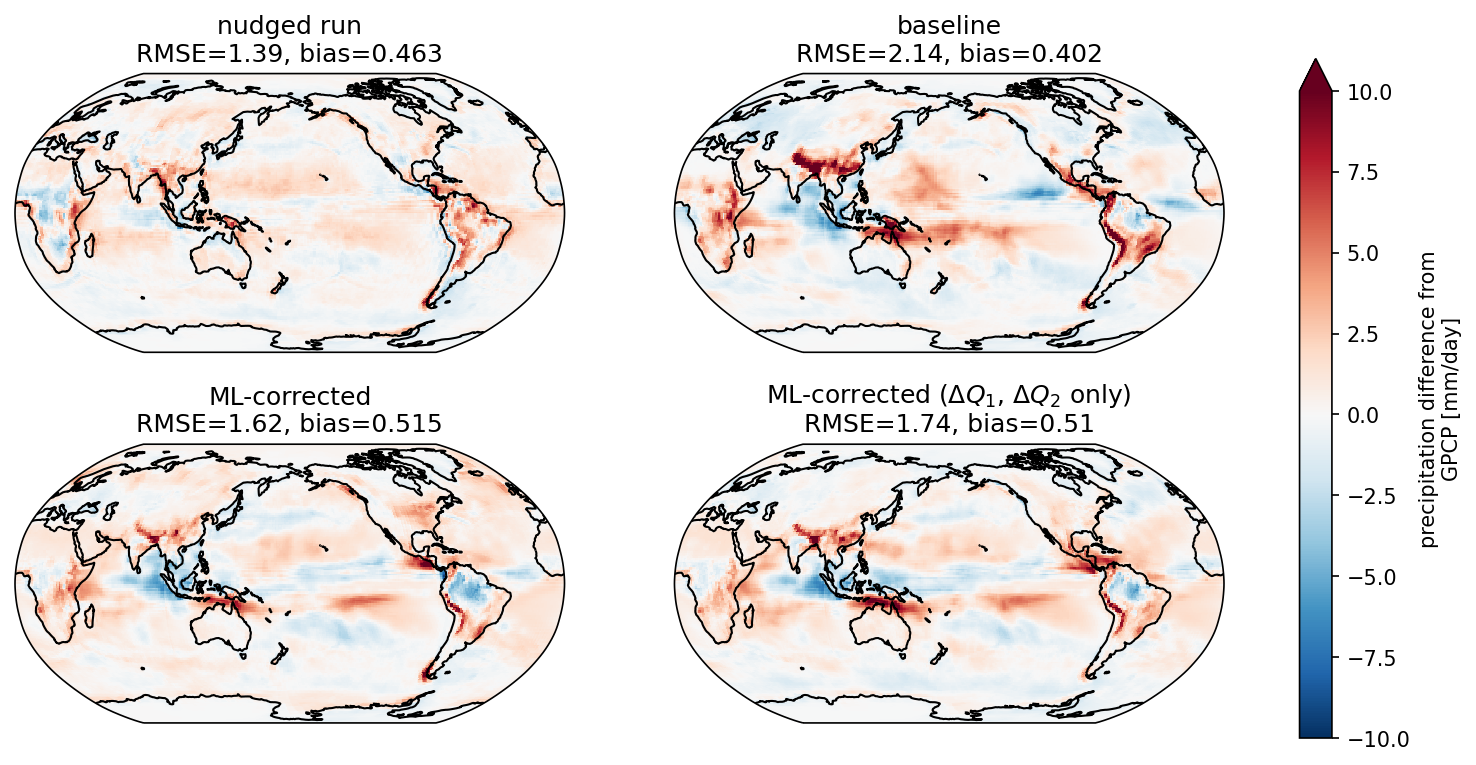

In [12]:
runs = ['nudged run', 'baseline', 'rf-control', 'rf-dQ1-dQ2-only']
fg = precip_bias_from_GPCP.sel(experiment=runs).plot(col='experiment', col_wrap=2, robust=True, vmin=-10, vmax=10, cmap='RdBu_r', **plot_kwargs)
for ax in fg.axes.flat:
    ax.coastlines()
for i, run in enumerate(precip_bias_from_GPCP.sel(experiment=runs).experiment):
    run_label = run.values.item()
    rmse = precip_rmse[run_label]['precip_rmse']
    bias = precip_global_bias[run_label]['precip_bias']
    fg.axes.flat[i].set_title(f"{run_titles[run_label]}\nRMSE={rmse:.3}, bias={bias:.3}")